In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import jax
import jax.numpy as jnp
import jax.random as r
import distrax as dx
import matplotlib.pyplot as plt

In [58]:
from typing import TypeVar

In [21]:
import sys
import os

# Navigate the current notebook directory to src directory
current_dir = os.getcwd()
jax_eco_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(jax_eco_dir, 'src')
sys.path.append(jax_eco_dir)

# Now you can import the module
import src.gp_from_scratch as g

In [94]:
key0 = r.PRNGKey(0)

In [93]:
# 1D test
x = jnp.linspace(start=0, stop=1, num=10).reshape(-1, 1)

GP0 = g.GP(mean=g.ZeroMean(), kernel=g.RBFKernel(lengthscale=0.1))

In [95]:
# mvn = GP0.mvn(x)
# y = mvn.sample(seed=key0)
# print(mvn.log_prob(y))

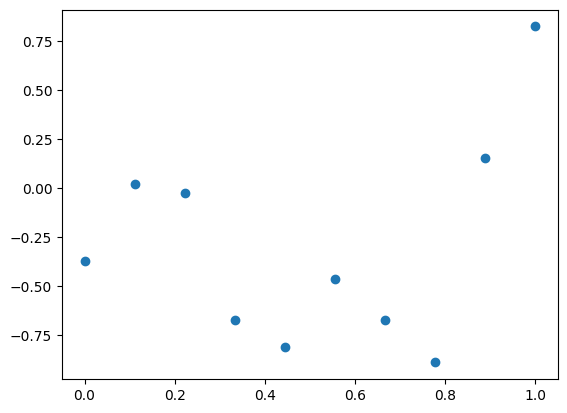

In [ ]:
y = GP0.sample(x=x, key=key0)fig, ax = plt.subplots(ncols=1, figsize=(15, 6))
ax.scatter(range(len(mcmc_samples)), mcmc_samples)
ax.plot(range(len(mcmc_samples)), mcmc_samples, linestyle='-', linewidth=0.5, color='gray')
ax.set_xlabel("Samples")
ax.set_ylabel("lengthscale")
plt.scatter(x, y)

In [50]:
cGP = GP0.condition(x, y)

In [51]:
fine_grid = jnp.linspace(start=0, stop=1, num=1000).reshape(-1, 1)
mean = cGP.mean(fine_grid)

(1000, 1) (10, 1)


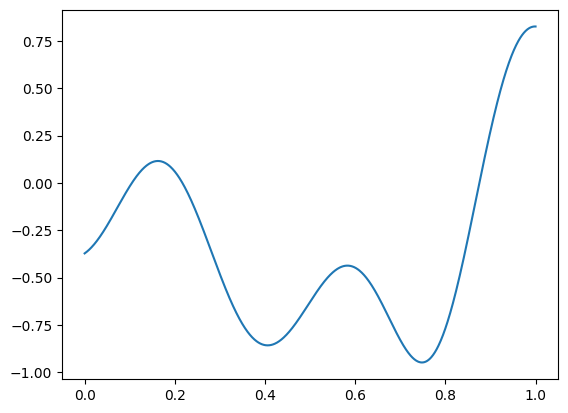

In [52]:
plt.plot(fine_grid, mean)

# Parametrised GP...

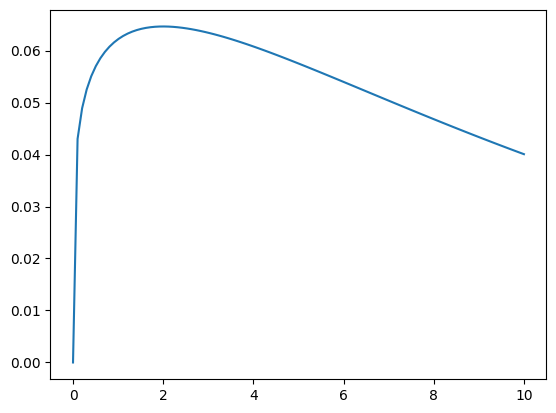

In [92]:
# plot the density of a diffuse gamma
gamma = dx.Gamma(concentration=1.2, rate=0.1)
grid = jnp.linspace(0, 10, 100)
plt.plot(grid, jnp.exp(gamma.log_prob(grid)))

In [156]:
# one parameter family over lengthscale
# GP0 = g.GP(mean=g.ZeroMean(), kernel=g.RBFKernel(lengthscale=0.1))

pfloat = TypeVar('(strictly) positive float', bound=float)
def prior_log_prob(lengthscale: pfloat):
    """Place a diffuse gamma prior on the lengthscale."""
    return dx.Gamma(concentration=1.2, rate=0.1).log_prob(lengthscale)

def spawn_RBF_GP(lengthscale: pfloat):
    return g.GP(mean=g.ZeroMean(), kernel=g.RBFKernel(lengthscale=lengthscale))

p_rbf_gp = g.ParametrisedGP(
    param_log_prob=prior_log_prob,
    spawn=spawn_RBF_GP,
    initializer=lambda _: jnp.array(0.1)
)

In [ ]:
opt_ps = p_rbf_gp.compute_map_params_lbfgs(
    key=key0, max_iter=100
)
print('Maximum a priori: ', opt_ps)

In [169]:
print('Now for conditioning; using x,y of shapes:', x.shape, y.shape)
cond_p_rbf_gp = p_rbf_gp.condition(x, y)

Now for conditioning; using x,y of shapes: (10, 1) (10,)


0.15420347


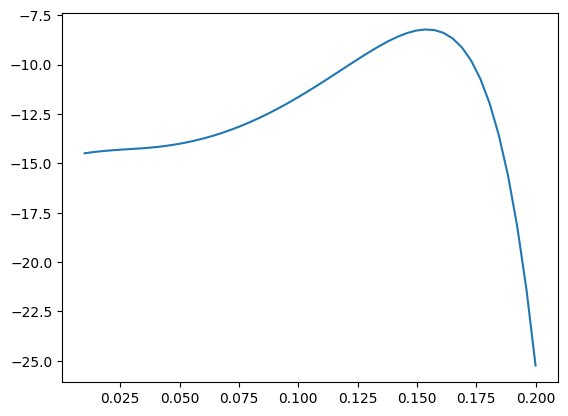

In [168]:
# investigate posterior over params...
# MAP
opt_ps = cond_p_rbf_gp.compute_map_params_lbfgs(
    key=key0, max_iter=100
)
print(opt_ps)

# plot the log density of posterior
grid = jnp.linspace(0.01, 0.2, 50)
log_dens = jax.vmap(cond_p_rbf_gp.param_log_prob)(grid)
plt.plot(grid, log_dens)

# Notice that the MAP is much higher than the true lengthscale of 0.1
# this is because, though the prior is diffuse, it is centered around lengthscale=2.0

Next up:
- implement a sample MAP method
- implement a sample Bayes with BlackJAX

In [171]:
log_prob_fn = cond_p_rbf_gp.param_log_prob

In [172]:
import blackjax as bx

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state
    
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

In [173]:
step_size = 1e-3
inverse_mass_matrix = jnp.array([1.])
num_integration_steps = 100

hmc = bx.hmc(log_prob_fn, step_size, inverse_mass_matrix, num_integration_steps)

initial_position = cond_p_rbf_gp.initializer(key0)
initial_state = hmc.init(initial_position)
initial_state

HMCState(position=Array(0.1, dtype=float32, weak_type=True), logdensity=Array(-11.650165, dtype=float32), logdensity_grad=Array(70.92478, dtype=float32, weak_type=True))

In [174]:
hmc_kernel = jax.jit(hmc.step)

In [ ]:
rng_key, sample_key = r.split(key0)
states = inference_loop(sample_key, hmc_kernel, initial_state, 1000)

mcmc_samples = states.position

Text(0, 0.5, 'lengthscale')

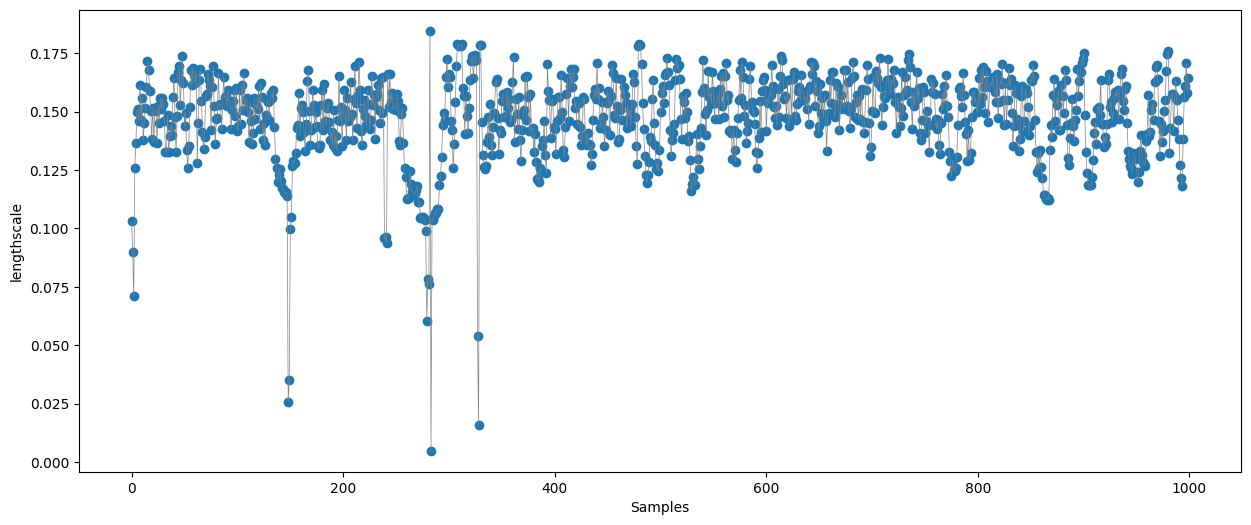

In [192]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 6))
ax.scatter(range(len(mcmc_samples)), mcmc_samples)
ax.plot(range(len(mcmc_samples)), mcmc_samples, linestyle='-', linewidth=0.5, color='gray')
ax.set_xlabel("Samples")
ax.set_ylabel("lengthscale")

# Nuts

In [195]:
nuts = bx.nuts(log_prob_fn, step_size, inverse_mass_matrix)
initial_state = nuts.init(initial_position)
initial_state

HMCState(position=Array(0.1, dtype=float32, weak_type=True), logdensity=Array(-11.650165, dtype=float32), logdensity_grad=Array(70.92478, dtype=float32, weak_type=True))

In [198]:
rng_key, sample_key = r.split(key0)
states = inference_loop(sample_key, nuts.step, initial_state, 10000)

mcmc_samples = states.position

Text(0, 0.5, 'lengthscale')

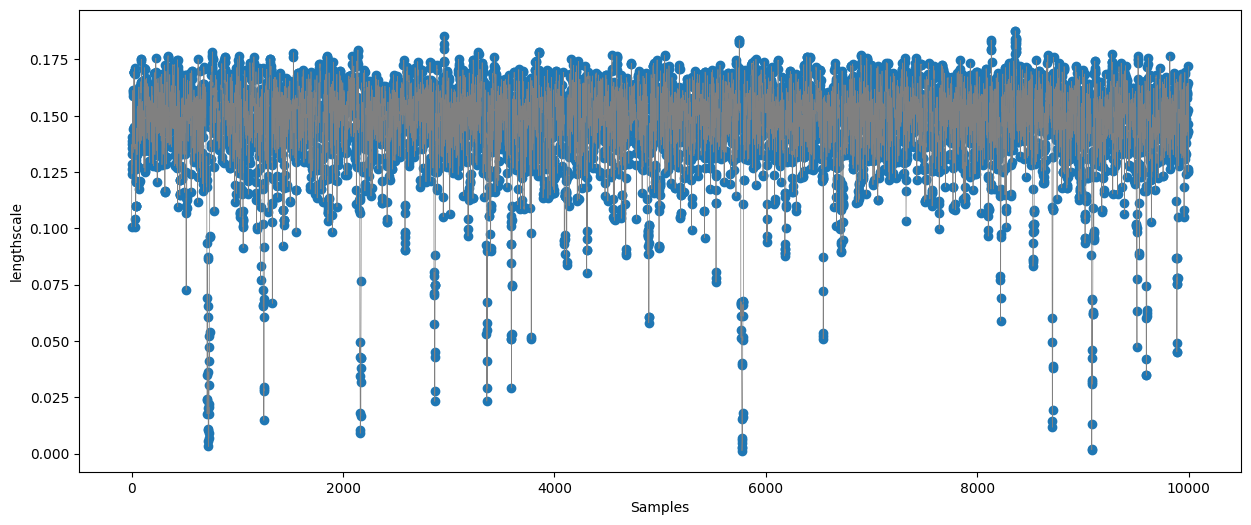

In [199]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 6))
ax.scatter(range(len(mcmc_samples)), mcmc_samples)
ax.plot(range(len(mcmc_samples)), mcmc_samples, linestyle='-', linewidth=0.5, color='gray')
ax.set_xlabel("Samples")
ax.set_ylabel("lengthscale")

Note - here the JAX call really was blisteringly fast - far faster than the plotting code!
Also, note that this was for the posterior of the kernel parameters - so the density itself was non-trivial.